In [22]:
import pandas as pd

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


El conjunto de datos en crudo nos serviría para realizar un proceso de Machine Learning usual como los que hemos visto en pasados módulos. En esta ocasión, necesitamos aplicar una transformación del mismo para generar una serie temporal con dos dimensiones: la temporal y la del dato que queremos analizar y predecir. En este caso la dimensión temporal estará compuesta por el mes (month) y el año (year) y el dato que observaremos a lo largo del tiempo será el número de pasajeros (passengers).


En este caso como tenemos el date completo no hace falta poner month y years

In [23]:
total_data["date"] = pd.to_datetime(total_data.date)
total_data = total_data.set_index("date")
ts_total = total_data["sales"]
ts_total.head()


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

A continuación visualizaremos la serie temporal para llevar a cabo un análisis visual de la misma:

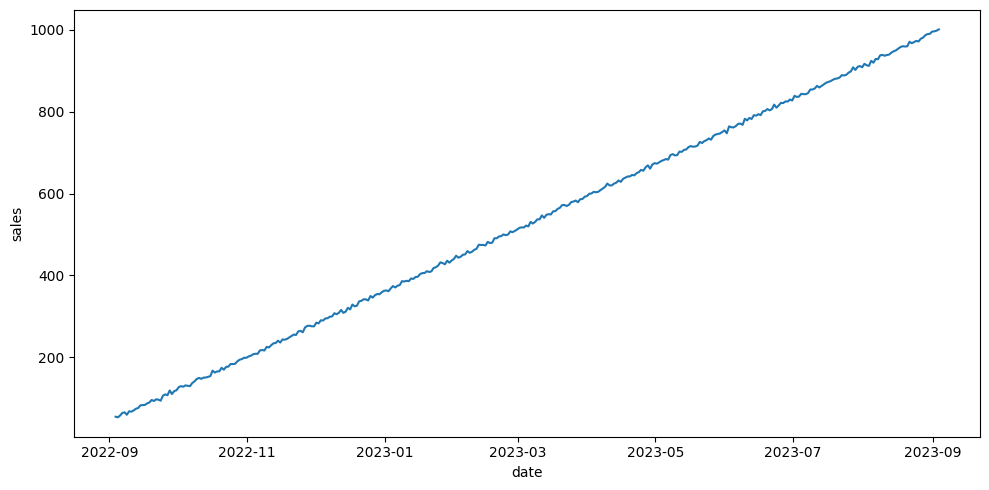

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)

plt.tight_layout()

plt.show()

Paso 2. Análisis de una serie temporal

La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función seasonal_decompose de la biblioteca statsmodels para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuos.

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_total, period = 7)
decomposition

Análisis de la tendencia


La tendencia se refiere a la dirección general en la que se mueven los datos. Para acceder a su información recurrimos a la componente trend de la descomposición.

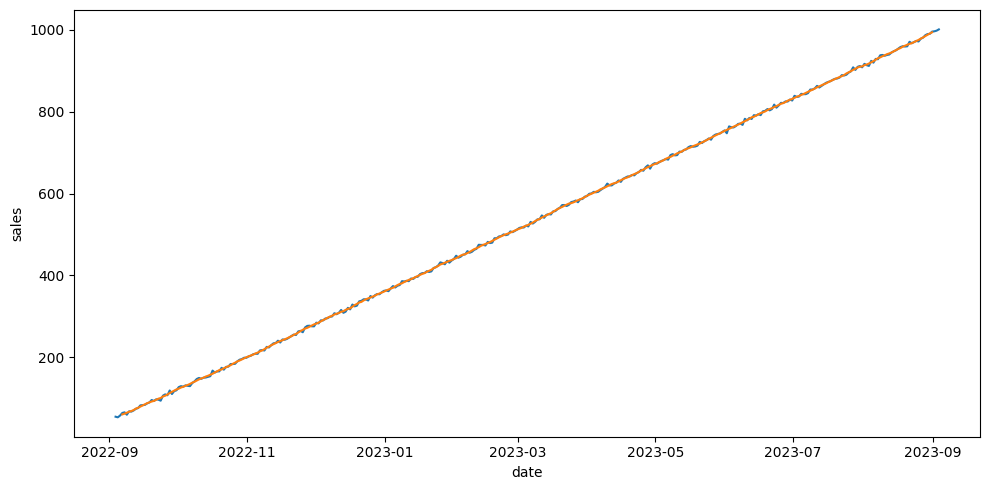

In [26]:

trend = decomposition.trend

fig, axis = plt.subplots(figsize=(10, 5))

# Trazar la serie temporal original y la tendencia
sns.lineplot(data=ts_total)
sns.lineplot(data=trend)


plt.tight_layout()

plt.show()

Se aprecia una tendencia al alza en los datos

Análisis de la estacionalidad


La tendencia se refiere a los patrones repetitivos en los datos. Para acceder a su información recurrimos a la componente seasonal de la descomposición.

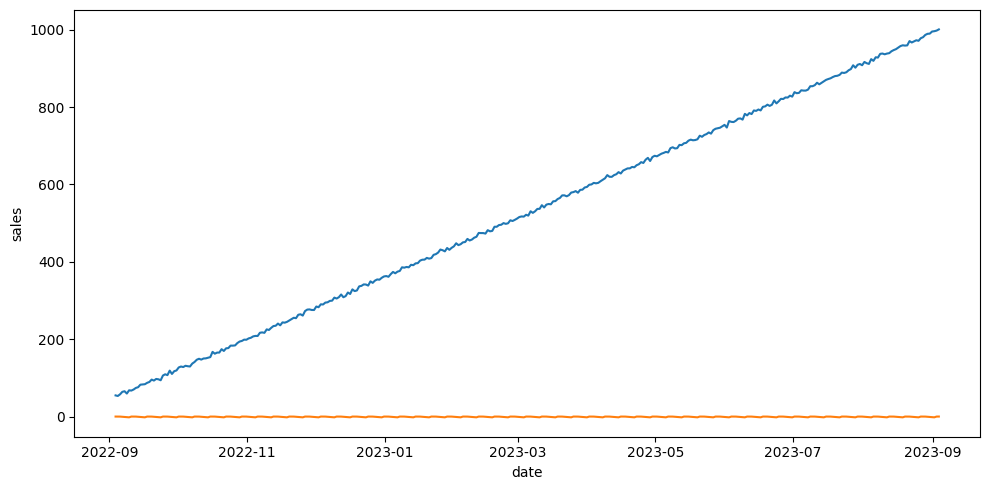

In [27]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionariedad de las series temporales podemos aplicar el llamado test de Dickey-Fuller, que es un test de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa es que es no estacionaria:

In [28]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts_total)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Estos son los resultados de la prueba de Dickey-Fuller:

Test Statistic: El valor del estadístico de la prueba es 0.545414.

p-value: El valor p obtenido es 0.986190. El p-value es un valor que nos indica la probabilidad de obtener un estadístico de prueba al menos tan extremo como el que se observó, bajo la hipótesis nula de que la serie temporal no es estacionaria. En este caso, un valor p alto sugiere que no tenemos suficiente evidencia para rechazar la hipótesis nula, lo que indica que la serie temporal no es estacionaria.

#Lags Used: Se utilizaron 13 rezagos en la regresión.

Number of Observations Used: Se utilizaron 352 observaciones en el análisis.

Critical Values: Estos son los valores críticos para diferentes niveles de significancia. Estos valores se utilizan para comparar el valor del estadístico de prueba y determinar si podemos rechazar la hipótesis nula. En este caso, como el valor del estadístico de prueba es mayor que el valor crítico en todos los niveles de significancia, no podemos rechazar la hipótesis nula de que la serie temporal no es estacionaria.

En resumen, basado en los resultados de la prueba de Dickey-Fuller, la serie temporal parece no ser estacionaria ya que el valor p es alto y el estadístico de prueba no es menor que los valores críticos en ningún nivel de significancia.



Análisis de la variabilidad

La variabilidad implica el estudio de los residuos: que es cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad. Para acceder a su información recurrimos a la componente resid de la descomposición.

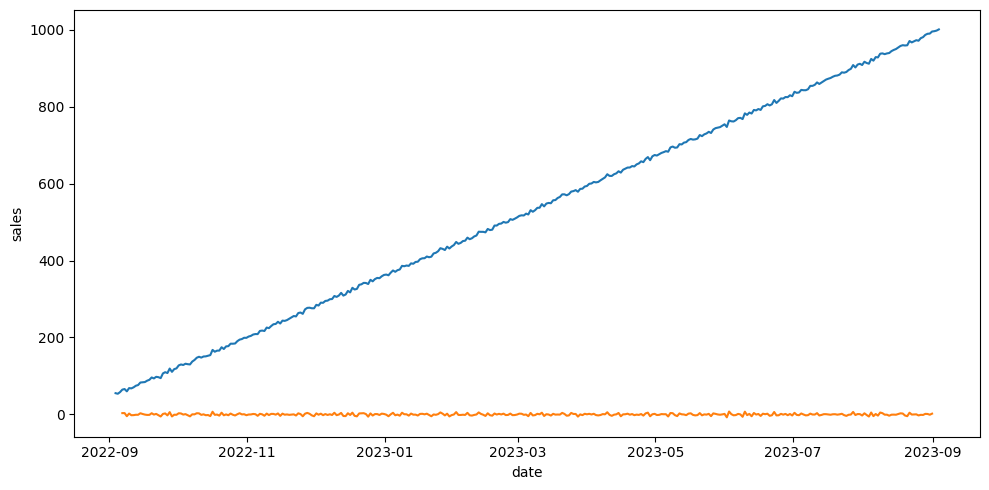

In [29]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = residual)


plt.tight_layout()

plt.show()

El gráfico muestra una serie temporal residual con alta variabilidad y presencia de valores atípicos, particularmente durante períodos de alta carga de CPU. Los valores del residuo cambian significativamente a lo largo del tiempo, lo que indica una variabilidad alta en la serie temporal residual.

 



Análisis de la autocorrelación

La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores

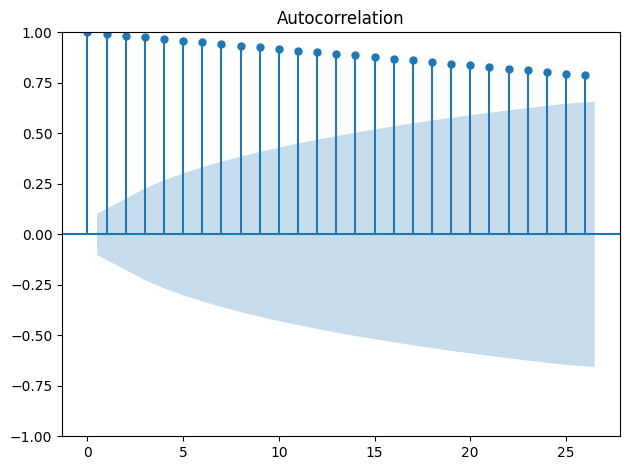

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_total)

plt.tight_layout()

plt.show()

Si la autocorrelación disminuye significativamente a medida que avanza en la serie temporal, puede ser más difícil para un modelo de predicción capturar y explotar patrones de autocorrelación en los datos para hacer predicciones precisas. Esto se debe a que la información sobre las observaciones anteriores puede volverse menos útil a medida que avanza en el tiempo, lo que dificulta la predicción de valores futuros

 



 Paso 3: Entrenamiento del modelo

 ARIMA

In [31]:
ts_stationary = ts_total.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

 Seasonal=True, el modelo ARIMA ajustado será un modelo SARIMA que tiene en cuenta la estacionalidad en los datos, mientras que al establecer seasonal=False, el modelo ajustado será un modelo ARIMA estándar que no considera la estacionalidad. La elección entre seasonal=True y seasonal=False depende de si los datos tienen o no patrones estacionales que deben ser capturados por el modelo.

 ("M") Puedes especificar cualquier valor que refleje la frecuencia de la estacionalidad en tus datos. Si los ciclos estacionales se repiten cada 7 días, entonces m=7 es apropiado. Si los ciclos se repiten cada 12 meses, entonces m=12 es apropiado. La elección de m depende de la periodicidad de la estacionalidad en tus datos.

 Sí, el parámetro m solo se utiliza cuando seasonal=True. Cuando seasonal=False, auto_arima ajustará un modelo ARIMA estándar que no considera componentes estacionales en los datos.

Si estableces seasonal=False, el parámetro m no tiene ningún efecto y se ignora en el ajuste del modelo. En este caso, auto_arima ajustará un modelo ARIMA estándar que solo tiene en cuenta la dependencia temporal no estacional de los datos, utilizando los parámetros p, d, y q para modelar la parte autorregresiva, integrada y de media móvil respectivamente.

In [32]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 7)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2096.542, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1966.396, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1970.972, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=1968.120, Time=0.34 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=1968.220, Time=0.35 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=1966.919, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=1965.376, Time=0.94 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=1965.211, Time=1.23 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=1963.937, Time=0.90 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=1967.822, Time=0.26 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=2094.918, Time=0.68 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=1911.553, Time=0.94 sec
 ARIMA(2,0,0)(0,0,2)

Es un modelo ARIMA con los siguientes parámetros:

Componentes ARIMA: (1, 0, 1)

p = 1: Orden del componente autorregresivo.
d = 0: Orden del componente de integración.
q = 1: Orden del componente de media móvil.

Componentes estacionales: (0, 0, 0, 0)

P = 0: Orden del componente autorregresivo estacional.
D = 0: Orden del componente de diferenciación estacional.
Q = 0: Orden del componente de media móvil estacional.
s = 0: Frecuencia estacional.



El mejor modelo ajustado es un ARIMA(1,0,1)(0,0,0)[0] con un término de intercepto. Esto significa que el modelo tiene en cuenta la dependencia temporal no estacional de los datos, así como la autocorrelación de las observaciones inmediatas (con p=1 y q=1) y un término de intercepto adicional. No hay componentes estacionales en este modelo, ya que todos los términos estacionales son cero.

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 7)   Log Likelihood                -911.986
Date:                            Fri, 09 Feb 2024   AIC                           1837.972
Time:                                    19:49:24   BIC                           1865.271
Sample:                                09-04-2022   HQIC                          1848.821
                                     - 09-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1216      0.290      7.315      0.000       1.553       2.690
ar.L1         -0.0774      0.054     -1.427      0.154      -0.184       0.029
ar.L2          0.0470      0.060      0.781      0.435      -0.071       0.165
ar.L3          0.0724      0.057      1.276      0.202      -0.039       0.184
ma.L1         -0.9787      0.020    -49.880      0.000      -1.017      -0.940
ar.S.L7        0.1481      0.055      2.707      0.007       0.041       0.255
sigma2         8.8359      0.714     12.377      0.000       7.437      10.235
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.61   Prob(JB):                         0.79
Heteroskedasticity (H):               0.86   Skew:                             0.06
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Paso 3: Predicción del modelo

In [34]:
forecast = model.predict(10)
forecast

2023-09-04 17:10:08.079328    2.097971
2023-09-05 17:10:08.079328    2.615429
2023-09-06 17:10:08.079328    2.284769
2023-09-07 17:10:08.079328    2.940115
2023-09-08 17:10:08.079328    2.340791
2023-09-09 17:10:08.079328    2.437700
2023-09-10 17:10:08.079328    2.673627
2023-09-11 17:10:08.079328    2.525567
2023-09-12 17:10:08.079328    2.601195
2023-09-13 17:10:08.079328    2.552504
Freq: D, dtype: float64

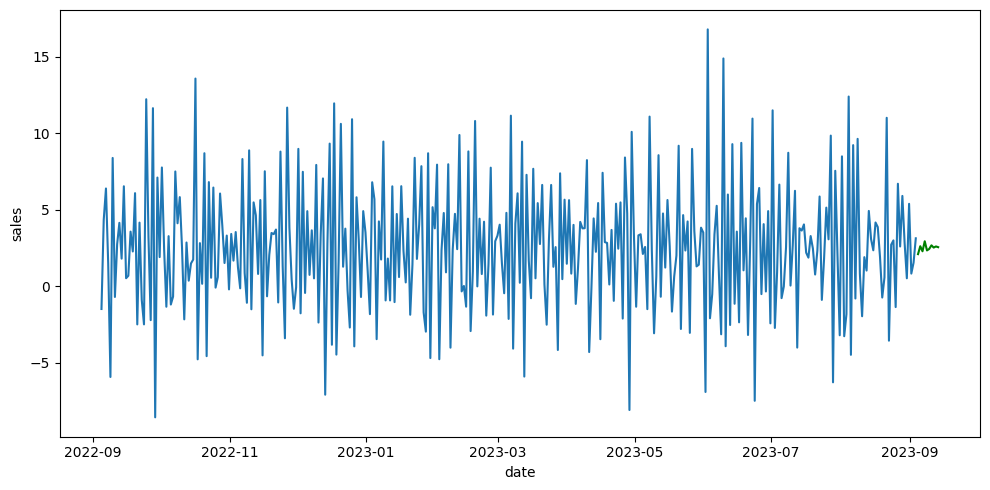

In [36]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()